# Exploratory Data Analysis

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.io import imread, imshow
from skimage import transform, img_as_float
import glob
import math

In [5]:
#get and print current directory
cwd = os.getcwd()
cwd

'C:\\Work\\Kaggle\\Planet\\kaggle_UnderstandingAmazonFromSpace'

In [6]:
#open data from current directory. Should work with any direcotry path
with open(os.path.join(cwd, "data", "train.csv")) as file:
    tagged_df = pd.read_csv(file)
tagged_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [7]:
#split the tags into new rows
tagged_df = pd.DataFrame(tagged_df.tags.str.split(' ').tolist(), index=tagged_df.image_name).stack()
tagged_df = tagged_df.reset_index()[[0, 'image_name']] # dataframe with two columns
tagged_df.columns = ['tags', 'image_name'] # rename columns
tagged_df.set_index('image_name', inplace=True) # rest index to image_name again

#create dummy variables for each tag
tagged_df = pd.get_dummies(tagged_df['tags']) # creates dummy rows
tagged_df = tagged_df.groupby(tagged_df.index).sum() # adds dummy rows together by image_name index
tagged_df.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
train_0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
train_1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
train_10,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1
train_100,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
train_1000,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0


There are 17 unique tags in this data


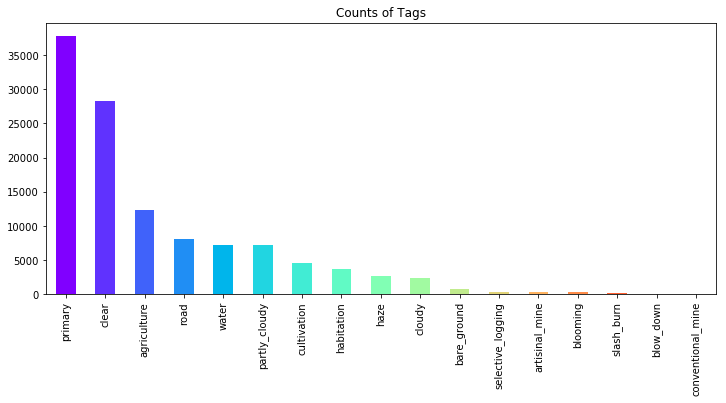

primary              37840
clear                28203
agriculture          12338
road                  8076
water                 7262
partly_cloudy         7251
cultivation           4547
habitation            3662
haze                  2695
cloudy                2330
bare_ground            859
selective_logging      340
artisinal_mine         339
blooming               332
slash_burn             209
blow_down              101
conventional_mine      100
dtype: int64

In [8]:
#Barplot of tag counts
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)
print('There are {} unique tags in this data'.format(len(tagged_df.columns)))
colors = cm.rainbow(np.linspace(0, 1, len(tagged_df.columns)))
tagged_df.sum().sort_values(ascending=False).plot(title="Counts of Tags", color=colors, kind='bar')
plt.show()
tagged_df.sum().sort_values(ascending=False)

# Load Image Data

In [16]:
def load_training_data(ftype='jpg'):
    train_imgs = []
    labels = []
    print('Loading {} image dataset'.format(ftype))
    path = os.path.join('data','train-{}-sample'.format(ftype),'*.'+ftype)
    files = glob.glob(path)
    for fs in files:
        img = imread(fs)
        # img = transform.resize(img, output_shape=(h,w,d), preserve_range=True)  if needed
        train_imgs.append(img)
        
        imname = os.path.basename(files[1]).split('.')[0]
        labels_temp = tagged_df.loc[imname]
        labels.append(labels_temp)
        
    train_imgs = np.asarray(train_imgs)
    return train_imgs, labels

In [17]:
X_train, y_train = load_training_data()

Loading jpg image dataset


In [18]:
# 100 files, images are 256x256 pixels, with a channel dimension size 3 = RGB
print('X_train is a {} object'.format(type(X_train)))
print('it has shape {}'.format(X_train.shape))

X_train is a <class 'numpy.ndarray'> object
it has shape (100, 256, 256, 3)


In [19]:
print('y_train is a {} object'.format(type(y_train)))
print('it has {} elements'.format(len(y_train)))
print('each element is of type {}'.format(type(y_train[0])))
print('and the elements are of size {}'.format(y_train[0].shape))

y_train is a <class 'list'> object
it has 100 elements
each element is of type <class 'pandas.core.series.Series'>
and the elements are of size (17,)


In [20]:
def get_labels(fname):
    return ", ".join(tagged_df.loc[fname][tagged_df.loc[fname]==1].index.tolist())    

In [21]:
def plot_samples(nrow, ncol):
    sampling = np.random.randint(low=0, high=X_train.shape[0]-1, size = nrow*ncol)
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 12))
    for i in range(0,len(sampling)):
        name = tagged_df.index[sampling[i]]
        tags = get_labels(name)

        row = math.floor(i/ncol)
        col = i - math.floor(i/ncol)*ncol
        if (nrow == 1 or ncol == 1):
            ind = (max(row,col))
        else:
            ind = (row,col)
        axes[ind].imshow(X_train[sampling[i]])
        axes[ind].set_title(name+'\n'+tags)
        axes[ind].tick_params(left=False, right=False)
        axes[ind].set_yticklabels([])
        axes[ind].set_xticklabels([])
    plt.tight_layout()

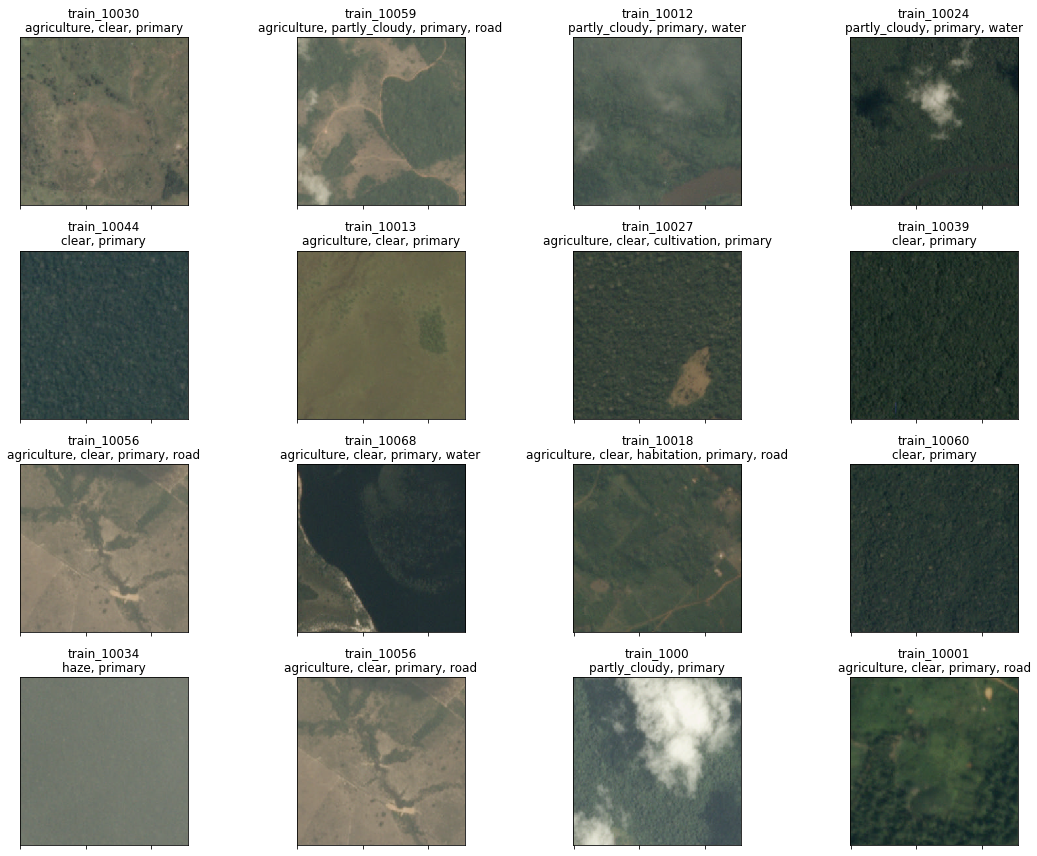

In [23]:
plot_samples(4,4)

# Feature Engineering
What type of features are we working with here?

In [83]:
print("There are {} unique features per image".format((256*256)*3))

There are 196608 unique features per image


In [112]:
red = X_train[:,:,:,0].reshape(100, 256*256) # row of red pixel features for all images
green = X_train[:,:,:,1].reshape(100, 256*256) # row of blue pixel features for all images
blue = X_train[:,:,:,2].reshape(100, 256*256) #row of green pixel features for all images

array([[105, 102, 101, ..., 104, 103,  98],
       [ 55,  56,  59, ...,  74,  80,  84],
       [ 46,  44,  43, ...,  53,  53,  52],
       ..., 
       [ 63,  63,  64, ...,  62,  60,  55],
       [ 48,  53,  55, ...,  67,  65,  62],
       [108, 101,  94, ...,  93,  94,  95]], dtype=uint8)

In [135]:
red = pd.DataFrame(red, index=???)

MemoryError: 